In [1]:
import os
import itertools # helpful library for iterating through things
import re
import numpy as np
import pandas as pd
from pprint import pprint

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

from gensim.models import Word2Vec 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# spacy for lemmatization
import spacy
def head(stream, n=10):
    return list(itertools.islice(stream, n))

import shutil

main_dir = "../all_news"
main_dir

'../all_news'

In [3]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [4]:
def measure_semantic_shift_by_neighborhood(model1,model2,word,k=25,verbose=False):
    """
    Basic implementation of William Hamilton (@williamleif) et al's measure of semantic change
    proposed in their paper "Cultural Shift or Linguistic Drift?" (https://arxiv.org/abs/1606.02821),
    which they call the "local neighborhood measure." They find this measure better suited to understand
    the semantic change of nouns owing to "cultural shift," or changes in meaning "local" to that word,
    rather than global changes in language ("linguistic drift") use that are better suited to a
    Procrustes-alignment method (also described in the same paper.)
    Arguments are:
    - `model1`, `model2`: Are gensim word2vec models.
    - `word` is a sting representation of a given word.
    - `k` is the size of the word's neighborhood (# of its closest words in its vector space).
    """
    # Import function for cosine distance
    from scipy.spatial.distance import cosine

    # Check that this word is present in both models
    if not word in model1.wv.vocab or not word in model2.wv.vocab:
        print("!! Word %s not present in both models." % word)
        return None

    # Get the two neighborhoods
    neighborhood1 = [w for w,c in model1.most_similar(word,topn=k)]
    neighborhood2 = [w for w,c in model2.most_similar(word,topn=k)]

    # Print?
    if verbose:
        print('>> Neighborhood of associations of the word "%s" in model1:' % word)
        print(', '.join(neighborhood1))
        print()
        print('>> Neighborhood of associations of the word "%s" in model2:' % word)
        print(', '.join(neighborhood2))

    # Get the 'meta' neighborhood (both combined)
    meta_neighborhood = list(set(neighborhood1)|set(neighborhood2))

    # Filter the meta neighborhood so that it contains only words present in both models
    meta_neighborhood = [w for w in meta_neighborhood if w in model1.wv.vocab and w in model2.wv.vocab]

    # For both models, get a similarity vector between the focus word and all of the words in the meta neighborhood
    vector1 = [model1.similarity(word,w) for w in meta_neighborhood]
    vector2 = [model2.similarity(word,w) for w in meta_neighborhood]

    # Compute the cosine distance *between* those similarity vectors
    dist=cosine(vector1,vector2)

    # Return this cosine distance -- a measure of the relative semantic shift for this word between these two models
    return dist

In [5]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [6]:
def iter_docs(base_dir):
    data = [] 
    docs = os.listdir(base_dir)
    count =0
    for doc in docs:
        if not doc.startswith('.') and doc.endswith('.txt'):
            print(count)
            count = count + 1
            with open(base_dir + doc, "r") as file:
                text = file.read()
                # Replaces escape character with space 
                f = text.replace("\n", " ") 
                # iterate through each sentence in the file 
                for i in sent_tokenize(f): 
                    temp = [] 

                    # tokenize the sentence into words 
                    for j in word_tokenize(i): 
                        if j not in stopwords.words('english'):
                            temp.append(j.lower()) 
                        else:
                            continue

                    data.append(temp) 
    return(data)

In [10]:
def word2vec_embeddings(base_dir, save_dir, save_name, min_count = 1, size = 100, window = 5):
    stream = iter_docs(base_dir)
    model = gensim.models.Word2Vec(stream, min_count = min_count, size = size, window = window)
    
    save_name = save_name + ".model"
    name = os.path.join(save_dir, save_name) 
    
    
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    model.save(name)
    
    return(model)

# Full Corpus Embeddings

In [11]:
overall_model = word2vec_embeddings("../topic_model/test/", "./overall_files", "overall")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


/Users/alexfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/alexfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


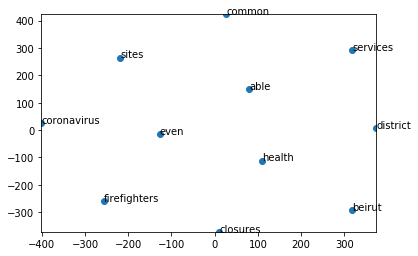

In [12]:
display_closestwords_tsnescatterplot(overall_model, "coronavirus", 100)

# Embeddings by Source Lean Buckets

In [ ]:
folder_list = []
for folder in sorted(os.listdir('../fan_project_news_stories')):
    if not folder.startswith("."):
        if len([name for name in os.listdir('../fan_project_news_stories/' + folder)]) > 100 and folder != "investor's_business_daily" and folder != "twincities-pioneer_press" and folder != "austin_american-statesman":
            folder_list.append(folder)
folder_list_series = pd.Series(folder_list, name = 'folder')

In [ ]:
# should append 1:1 because both are sorted
source_biases = pd.read_csv('../topic_model/topic_averages_w_biases_new.csv')
source_biases['folder_name'] = folder_list_series

In [ ]:
# create list of directories based on source bias bucket series
to_dir = source_biases['lean_buckets'].unique().tolist()
news_source_split_name = "../news_source_splits"

for directory in to_dir:
    path = os.path.join(news_source_split_name, directory)
    print(path)
    if not os.path.isdir(path):
        os.mkdir(os.path.join(news_source_split_name, directory))
    

In [ ]:
for split in os.listdir("../news_source_splits"):
    print("{}: {}".format(split, len(os.listdir(os.path.join(news_source_split_name, split)))))

In [ ]:
# move text to new folder
for folder in sorted(os.listdir('../fan_project_news_stories')):
    if not folder.startswith(".") and folder in source_biases['folder_name'].tolist():
        
        # locate the bias label
        source_bias = source_biases.loc[source_biases['folder_name'] == folder, 'lean_buckets'].iloc[0]
        
        # move the docs in news source folder to new bias split designations
        for doc in os.listdir("../fan_project_news_stories/" + folder):
            
            if doc.endswith(".txt"):
                shutil.copy2("../fan_project_news_stories/" + folder + "/" + doc, 
                  os.path.join('{}/{}'.format(news_source_split_name, source_bias))
                )
            

In [ ]:
# make the word embeddings
model_source_dir_name = './word2vec_mini_models_by_time'

if not os.path.isdir(model_source_dir_name):
    os.mkdir(model_source_dir_name)
for directory in to_dir:
    path = os.path.join(news_source_split_name, directory)+'/'
    print(path)
    stream = iter_docs(path)
    model1 = gensim.models.Word2Vec(stream, min_count = 1,  
                              size = 100, window = 5) 
    model1.save("{}/{}_word2vec.model".format(model_source_dir_name, directory))
    

In [ ]:
models = {}
for model in os.listdir(model_source_dir_name):
    # reads in models into a dict, ignoring any of the residual trainable files
    if model.endswith(".model") and not model.endswith(".trainables"):
        models[model] = Word2Vec.load(model_source_dir_name + "/" + model)

In [ ]:
for key, value in models.items():
    word = "mask"
    print(key)
    
    if not word in value.wv.vocab:
        print(word + " not in the vocabulary of the model")
        continue
    
    display_closestwords_tsnescatterplot(value, word, 100)
    print("\n")

In [ ]:
measure_semantic_shift_by_neighborhood(models['left_leaning_word2vec.model'],
                                       models['right_leaning_word2vec.model'], "plandemic", verbose = True)

# Embeddings by Time

In [ ]:
## create new directory separated by date
doc_name = []
full_path_name = []
for news_source in os.listdir("../all_news"):
    if not news_source.startswith('.'):
        path = os.path.join("../all_news", news_source)
        full_path_name.append(path)
        doc_name.append(news_source)

    

In [ ]:
news_df = pd.DataFrame(list(zip(full_path_name, doc_name)), columns=['full_path_name', 'name'])
news_df['date'] = news_df['name'].str.split(pat="_").str[1]

# clean date
news_df['year'] =  news_df['date'].str.split(pat=".").str[0]
news_df['month'] =  news_df['date'].str.split(pat=".").str[1]
news_df['day'] =  news_df['date'].str.split(pat=".").str[2]
news_df['date_clean'] = news_df['year'] + news_df['month'] + news_df['day']
news_df['date_clean'] = pd.to_datetime(news_df['date_clean'], format="%Y%m%d")

In [ ]:
# remove any null dates
news_df = news_df[pd.notnull(news_df.date_clean)]

In [ ]:
# construct buckets
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 1, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 2, 1)), 'time_period'] = 'Jan_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 2, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 3, 1)), 'time_period'] = 'Feb_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 3, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 4, 1)), 'time_period'] = 'Mar_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 4, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 5, 1)), 'time_period'] = 'Apr_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 5, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 6, 1)), 'time_period'] = 'May_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 6, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 7, 1)), 'time_period'] = 'Jun_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 7, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 8, 1)), 'time_period'] = 'Jul_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 8, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 9, 1)), 'time_period'] = 'Aug_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 9, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 10, 1)), 'time_period'] = 'Sept_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 10, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 11, 1)), 'time_period'] = 'Oct_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 11, 1)) & (news_df['date_clean'] < datetime.datetime(2020, 12, 1)), 'time_period'] = 'Nov_2020'
news_df.loc[(news_df['date_clean'] >= datetime.datetime(2020, 12, 1)), 'time_period'] = 'Dec_2020'


In [ ]:
to_dir = news_df['time_period'].unique().tolist()
to_dir

In [ ]:
# make directories
news_time_split_name = "../news_time_splits"

for directory in to_dir:
    path = os.path.join(news_time_split_name, directory)
    print(path)
    if not os.path.isdir(path):
        os.mkdir(os.path.join(news_time_split_name, directory))
    

In [ ]:
# move text to new folder
for index, doc in news_df.iterrows():
    #print(os.path.join('../all_news_1106/fan_project_news_stories_by_date/{}'.format(doc['time_period']), doc['name']))
    shutil.copy2(doc['full_path_name'], 
                  os.path.join(news_time_split_name, doc['time_period'], doc['name'])
                )

In [ ]:
model_time_dir_name = './word2vec_mini_models_by_time'
if not os.path.isdir(model_time_dir_name):
    os.mkdir(model_time_dir_name)
for directory in to_dir:
    path = os.path.join(news_time_split_name, directory)+'/'
    print(path)
    stream = iter_docs(path)
    model1 = gensim.models.Word2Vec(stream, min_count = 1,  
                              size = 100, window = 5) 
    model1.save("{}/{}_word2vec.model".format(model_time_dir_name, directory))
    

In [ ]:
models_time = {}
for model in os.listdir(model_time_dir_name):
    # reads in models into a dict, ignoring any of the residual trainable files
    if model.endswith(".model") and not model.endswith(".trainables"):
        models[model] = Word2Vec.load(model_time_dir_name + '/'+ model)

In [ ]:
for key, value in models_time.items():
    word = "mask"
    print(key)
    
    if not word in value.wv.vocab:
        print(word + " not in the vocabulary of the model")
        continue
    
    display_closestwords_tsnescatterplot(value, word, 100)
    print("\n")